2025-06-05 16:37:32.639656: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-05 16:37:32.642653: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-05 16:37:32.651745: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749163052.667285 1786227 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749163052.672668 1786227 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749163052.685785 1786227 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

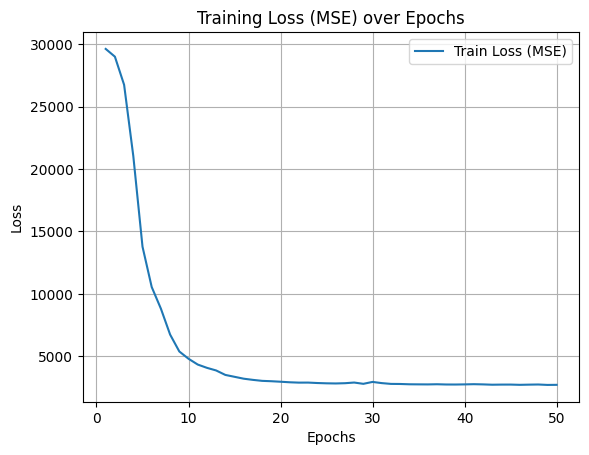

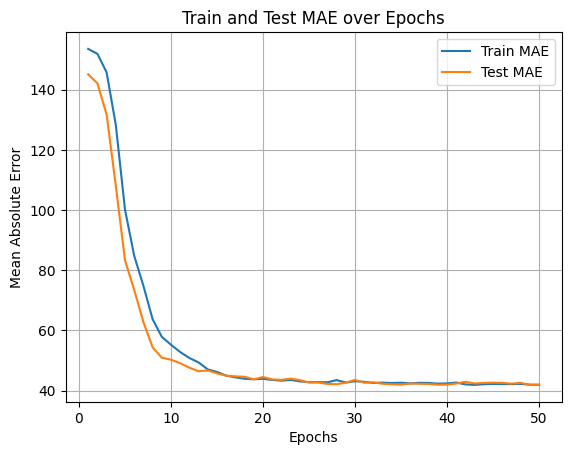

Final Training Loss (MSE): 2704.5020
Final Training MAE: 41.9288
Final Test MAE: 42.0217


In [1]:
# mlp_diabetes_keras.py

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback

# Cargar y preparar el dataset Diabetes
diabetes = load_diabetes()
X = diabetes.data
y = diabetes.target

# Dividir en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalización
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Callback para registrar tiempo por época
class TimingCallback(Callback):
    def on_train_begin(self, logs=None):
        self.logs = []
    def on_epoch_begin(self, epoch, logs=None):
        self.start_time = time.time()
    def on_epoch_end(self, epoch, logs=None):
        elapsed = time.time() - self.start_time
        self.logs.append(elapsed)

# Crear el modelo MLP para regresión
model = Sequential([
    InputLayer(input_shape=(X.shape[1],)),
    Dense(10, activation='relu'),
    Dense(2, activation='relu'),
    Dense(1)  # Salida escalar para regresión
])

model.compile(optimizer=Adam(learning_rate=0.01),
              loss='mean_squared_error',
              metrics=['mean_absolute_error'])

# Callback para tiempos
timing_cb = TimingCallback()

# Entrenamiento
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=50,
                    batch_size=16,
                    verbose=0,
                    callbacks=[timing_cb])

# Extraer métricas
epochs = list(range(1, 51))
train_loss = history.history['loss']
train_mae = history.history['mean_absolute_error']
test_mae = history.history['val_mean_absolute_error']
epoch_times = timing_cb.logs

# Guardar resultados en CSV
df = pd.DataFrame({
    'epoch': epochs,
    'train_loss': train_loss,
    'train_MAE': train_mae,
    'test_MAE': test_mae,
    'time': epoch_times
})
df.to_csv('ResultadosMLP_Diabetes.csv', index=False)

# Graficar pérdida (MSE)
plt.figure()
plt.plot(epochs, train_loss, label='Train Loss (MSE)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss (MSE) over Epochs')
plt.legend()
plt.grid(True)
plt.savefig('MLP_Diabetes_Loss.png')
plt.show()

# Graficar MAE
plt.figure()
plt.plot(epochs, train_mae, label='Train MAE')
plt.plot(epochs, test_mae, label='Test MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.title('Train and Test MAE over Epochs')
plt.legend()
plt.grid(True)
plt.savefig('MLP_Diabetes_MAE.png')
plt.show()

# Mostrar métricas finales
print(f"Final Training Loss (MSE): {train_loss[-1]:.4f}")
print(f"Final Training MAE: {train_mae[-1]:.4f}")
print(f"Final Test MAE: {test_mae[-1]:.4f}")
